# Proyecto Final Riesgo de Crédito

### Objetivos del proyecto

Los objetivos de este proyecto final son:
- analizar la información disponible de los aplicantes a un préstamo e identificar las posibles variables que determinen que el solicitante no pagará el préstamo
- analizar diferentes opciones de modelos de clasificación y seleccionar el que tenga la mejor performance en predecir si el solicitante pagará o no el préstamo

### Data Acquisition

In [32]:
# Importar librerías

# Operaciones Basicas
import numpy as np
import pandas as pd
import pandas_profiling

# Visualizacion de Datos
import matplotlib.pyplot as plt
import seaborn as sns

# Ocultar los mensajes de advertencia
import warnings
warnings.filterwarnings('ignore')

El dataset elegido fue Home Equity (HMEQ) de Kaggle: https://www.kaggle.com/datasets/ajay1735/hmeq-data  
HMEQ presenta información sobre las características y la morosidad de 5960 préstamos con garantía hipotecaria. Un préstamo con garantía hipotecaria es un préstamo en el que el deudor utiliza el capital de su vivienda como garantía subyacente.  
Los criterios de selección del dataset fueron la claridad de los datos recolectados y su robustez, lo que facilita el análisis, el procesamiento y la generación de un modelo.   
El dataset contiene las siguientes variables:
- BAD: Categoría de la persona candidata al préstamo. 1, corresponde al candidato con préstamo incumplido o con mora; 0, corresponde al candidato con préstamo al día  
- LOAN: Monto del préstamo solicitado
- MORTDUE: Monto adeudado de la hipoteca existente
- VALUE: Valor de la propiedad hipotecada
- REASON: Razón para solicitar el préstamo. DebtCon, corresponde a consolidación de deudas; HomeImp, corresponde a mejoras para el hogar
- JOB: Categoría profesional
- YOJ: Cantidad de años en el trabajo actual
- DEROG: Número de informes derogatorios importantes
- DELINQ: Número de líneas de crédito morosas
- CLAGE: Tiempo en meses de la línea de crédito de mayor antigüedad
- NINQ: Número de consultas crediticas recientes
- CLNO: Número de líneas de crédito
- DEBTINC: Relación deuda-ingreso. Es igual a la suma de todos los pagos de deuda del mes, dividida entre el ingreso bruto mensual


In [33]:
#Leer el dataset
historial_credito = pd.read_csv("hmeq.csv")
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [34]:
#Obtener el tamaño del dataset
print('El dataset tiene ' + str(historial_credito.shape[0]) + ' filas y ' + str(historial_credito.shape[1]) + ' columnas.')

El dataset tiene 5960 filas y 13 columnas.


In [35]:
#Mostrar el tipo de datos
historial_credito.dtypes

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [36]:
#Chequear si hay datos duplicados
historial_credito[historial_credito.duplicated()]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


No existen datos duplicados en el dataset.

In [37]:
#Obtener el número de datos nulos y su porcentaje comparado con el total
porcentaje_nulos = historial_credito.isnull().mean().round(4) *100
pd.merge(historial_credito.isnull().sum().reset_index(), porcentaje_nulos.reset_index(), how='inner', on='index', suffixes=("_Valores Nulos", "_Porcentaje de valores nulos"))


,index,0_Valores Nulos,0_Porcentaje de valores nulos
0,BAD,0,0.00
1,LOAN,0,0.00
2,MORTDUE,518,8.69
3,VALUE,112,1.88
4,REASON,252,4.23
5,JOB,279,4.68
6,YOJ,515,8.64
7,DEROG,708,11.88
8,DELINQ,580,9.73
9,CLAGE,308,5.17


'DEBTINC' es la columna que cuenta con mayor cantidad de valores nulos con un 21.26% del total.

### Data Wrangling

En esta sección prepararemos los datos, limpiándolos y unificándolos en caso de ser necesario para facilitar el acceso, el análisis y el modelado en profundidad.

In [38]:
#Eliminar filas o columnas que no serán utilizadas
historial_credito.drop('DEBTINC', axis=1, inplace=True)
historial_credito.dropna(axis=0, how='any', inplace=True)

- Excluimos del análisis la variable 'DEBTINC' ya que casi un tercio de sus datos son nulos.
- Decidimos excluir del primer análisis todos los registros con valores nulos.

Modificaremos las variables 'YOJ' y 'CLAGE' para ganar claridad. Para esto, transformaremos la variable 'YOJ' a una booleana de Empleo o Desempleo y transformaremos la variable 'CLAGE' de meses a años. 

In [39]:
#Utilizar una función lambda para agilizar el resultado
tiene_empleo = lambda x: False if x <=0 else True

#Aplicar la función a la nueva variable
historial_credito['Tiene_Empleo'] = historial_credito.YOJ.apply(tiene_empleo)

#Crear la variable Años_Credito
historial_credito['Años_Credito'] = (historial_credito['CLAGE'] / 12)

#Presentar los resultados
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,Tiene_Empleo,Años_Credito
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,True,7.863889
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,True,10.152778
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,True,12.455556
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,True,7.777778
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,True,8.455500


In [40]:
# Eliminar la variable 'CLAGE'
historial_credito.drop(['CLAGE'], axis=1, inplace=True)
historial_credito.head()


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,1.0,9.0,True,7.863889
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,0.0,14.0,True,10.152778
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,1.0,10.0,True,12.455556
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,0.0,14.0,True,7.777778
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,1.0,8.0,True,8.455500


In [41]:
#Crear la variable booleana Tiene_Empleo. Finalizar el Data Wrangling para proceder al análisis
historial_credito.Tiene_Empleo = historial_credito.Tiene_Empleo.replace({True: 1, False: 0})
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,1.0,9.0,1,7.863889
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,0.0,14.0,1,10.152778
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,1.0,10.0,1,12.455556
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,0.0,14.0,1,7.777778
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,1.0,8.0,1,8.455500


### Análisis Exploratorio de Datos (EDA)

En esta sección se analizan las principales características del conjunto de datos. Definimos a 'BAD' como variable target para dividir el conjunto de datos en submuestras y analizar sus características, la correlación entre variables y el potencial de clasificación.

In [42]:
#Descubrir la cantidad de candidatos morosos y de candidatos que pagan sus deudas
historial_credito.BAD.value_counts()

0    3407
1     840
Name: BAD, dtype: int64

Se observa que 840 de 4247 aplicantes tienen al menos una deuda morosa, lo que representa un 19.78% del total. A partir de ahora consideramos 'BAD' como nuestra variable target, recordando que el valor 1 corresponde al candidato con préstamo incumplido o con mora y que el valor 0 corresponde al candidato que tiene su deuda al día.  

#### *Estadísticas descriptivas de candidatos con préstamos pagados*

In [43]:
#Filtrar los préstamos pagados a partir de la variable 'BAD'
historial_credito[historial_credito['BAD']==0].drop('BAD', axis=1).describe().round(4)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
count,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000
mean,19032.4626,75954.3452,107528.8771,9.3108,0.1048,0.2157,1.0082,22.1256,0.9181,15.3406
std,10863.4585,44495.8932,53831.1805,7.6620,0.3936,0.6059,1.4620,9.1293,0.2742,6.7339
min,1700.0000,2619.0000,26000.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0406
25%,11900.0000,49000.0000,71355.0000,3.0000,0.0000,0.0000,0.0000,16.0000,1.0000,10.1470
50%,16900.0000,67285.0000,94613.0000,8.0000,0.0000,0.0000,1.0000,21.0000,1.0000,15.0609
75%,23800.0000,92693.5000,122328.5000,14.0000,0.0000,0.0000,2.0000,27.0000,1.0000,19.4947
max,89900.0000,371003.0000,471827.0000,36.0000,3.0000,4.0000,11.0000,56.0000,1.0000,54.1456


#### *Estadísticas descriptivas de candidatos con préstamos morosos*

In [44]:
#Filtrar los préstamos morosos a partir de la variable 'BAD'
historial_credito[historial_credito['BAD']==1].drop('BAD', axis=1).describe().round(4)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
count,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000
mean,16389.4048,68966.4455,97955.4343,7.8549,0.6762,1.1488,1.8440,22.1250,0.9548,12.4777
std,10861.3966,47625.8831,60299.8026,6.8546,1.4318,1.8631,2.2172,11.3532,0.2079,7.3822
min,1100.0000,2800.0000,12500.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,9000.0000,39552.0000,60498.2500,2.5000,0.0000,0.0000,0.0000,14.0000,1.0000,7.8784
50%,14600.0000,59374.5000,83000.0000,6.0000,0.0000,0.0000,1.0000,21.0000,1.0000,11.0011
75%,20650.0000,84985.5000,118031.2500,11.2500,1.0000,2.0000,3.0000,28.0000,1.0000,16.1591
max,77400.0000,399412.0000,512650.0000,41.0000,10.0000,15.0000,13.0000,65.0000,1.0000,97.3528


De las estadísticas descriptivas se pueden comenzar a perfilar algunas definiciones:

- La media de las variables de préstamo solicitado ('LOAN'), importe vencido de la hipoteca ('MORTDUE') y valor de la garantía ('VALUE') es mayor en el caso de las muestras de préstamos PAGADOS. Al tratarse de valores que no son significativamente diferentes, puede no existir un potencial para categorización.

- La media de años en el puesto de trabajo actual ('YOJ') sugiere que los préstamos MOROSOS son más frecuentes en los aplicantes con una menor antigüedad en sus trabajos actuales. Esta tendencia se observa también en los cuartiles.

- Luego, se puede observar el caso de las variables relacionadas con el historial crediticio de la persona que solicita el préstamo, como el número de informes derogatorios importantes ('DEROG'), el número de líneas de crédito en mora ('DELINQ'), la antigüedad de la línea de crédito ('CLAGE') y el número de consultas de crédito recientes ('NINQ'). En el caso de los préstamos MOROSOS, la distribución de estas variables sugiere un sesgo hacia peores historiales de crédito comparados con la distribución correspondiente para los préstamos PAGADOS.

- Finalmente, el la media de líneas de crédito abiertas ('CLNO') es similar en ambos casos, con lo que tampoco existiría un potencial significativo para categorización.

#### *Análisis Univariado*

count     4247.000000
mean     18509.700965
std      10912.687784
min       1100.000000
25%      11200.000000
50%      16300.000000
75%      23400.000000
max      89900.000000
Name: LOAN, dtype: float64

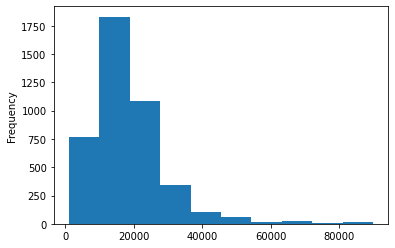

In [45]:
#Histograma de los montos correspondientes a préstamos
historial_credito['LOAN'].plot.hist()
historial_credito['LOAN'].describe()

<AxesSubplot:xlabel='LOAN'>

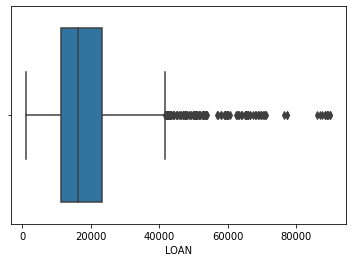

In [46]:
#Boxplot sobre los valores de los préstamos
from seaborn import boxplot
boxplot(historial_credito.LOAN)

La media del monto de los préstamos que tienen las personas se ubica por debajo de los USD 20000. Observamos una gran dispersión hacia la izquierda, entre valores por encima de los USD 40000.

#### *Análisis Bivariado*

In [47]:
#Hacer visible la diferencia entre préstamos morosos y préstamos pagados
historial_credito.loc[historial_credito.BAD == 1, 'STATUS'] = 'MOROSO'
historial_credito.loc[historial_credito.BAD == 0, 'STATUS'] = 'PAGADO'
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito,STATUS
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,1.0,9.0,1,7.863889,MOROSO
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,0.0,14.0,1,10.152778,MOROSO
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,1.0,10.0,1,12.455556,MOROSO
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,0.0,14.0,1,7.777778,PAGADO
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,1.0,8.0,1,8.455500,MOROSO


In [48]:
#Comparar las razones de los préstamos solicitados entre morosos y quienes pagan a término
historial_credito.loc[historial_credito.BAD == 1, 'STATUS'] = 'MOROSO'
historial_credito.loc[historial_credito.BAD == 0, 'STATUS'] = 'PAGADO'
g = historial_credito.groupby('REASON')
g['STATUS'].value_counts(normalize=True).to_frame().style.format("{:.1%}")

Se observa que no existe una diferencia significativa entre quienes pagaron sus deudas a término comparado con los morosos si los clasificamos de acuerdo a la variable 'REASON' (que diferencia entre razones de consolidación de deudas y de mejoras para el hogar).

#### *Análisis Multivariado*

<AxesSubplot:>

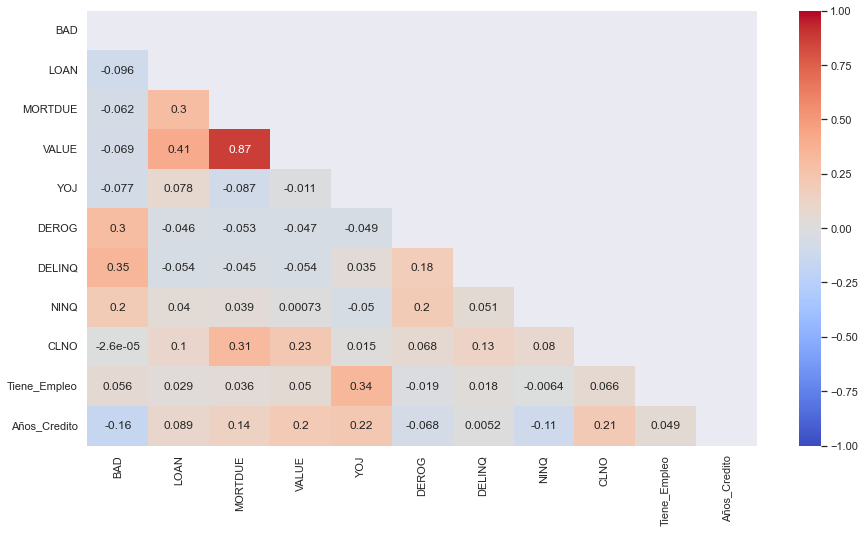

In [57]:
#Mapa de Correlación
upp_mat = np.triu(historial_credito.corr())

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(historial_credito.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

El mapa de correlaciones puede indicar una relación predictiva a ser explotada en el modelo de clasificación. Los colores más fríos corresponden a una baja correlación, los más cálidos corresponden a una alta correlación. 

Las variables relacionadas con el historial crediticio ('DELINQ', 'DEROG', 'NINQ') son las más correlacionadas con la variable target ('BAD'). Es un indicio de que éstas serán las variables de clasificación. Estas variables también están ligeramente correlacionadas entre sí sugiriendo que la información podría ser redundante.

El monto adeudado de la hipoteca existente ('MORTDUE') o el valor de la garantía subyacente ('VALUE') no parecen estar relacionados con el estado del préstamo. De todos modos, forman otro grupo de correlación con otras variables como los Años_Crédito y el número de líneas de crédito (CLNO).